In [1]:
from cursor1D_env import cursor1D_env

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# QNetwork

In [2]:
# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

class QNetwork(nn.Module):
# Define your network here

    def __init__(self,  state_size, action_size, hidden_size):
        super(QNetwork, self).__init__()
        
        #Set up the network
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
                

    def forward(self, x):        
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Replay Buffer

In [3]:
import random

class Replay():
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.

    def __init__(self, max_size=10000):
        self.size    = max_size
        self.buffer  = []
        self.pointer = 0
    
    def pushBack(self, state, action, reward, next_state, done):
        
        #if the list isn't at it's maximum capacity
        if(len(self.buffer) < self.size):
            self.buffer.append([state, action, reward, next_state, done])
            
        #Otherwise overwrite
        else:
            self.buffer[self.pointer] = [state, action, reward, next_state, done]
        
        #Update pointer
        self.pointer = (self.pointer + 1)%self.size
        
    def getRandom(self, batch_size):        
        return random.sample(self.buffer, batch_size)
    
    def getRandomSeperated(self, batch_size):
        batch = self.getRandom(batch_size)
        states      = []
        actions     = []
        rewards     = []
        next_states = []
        dones       = []

        for el in batch:
            states.append(el[0]); actions.append(el[1]); rewards.append(el[2]); next_states.append(el[3]); dones.append(el[4])
        
        return FloatTensor(states), LongTensor(actions), FloatTensor(rewards), FloatTensor(next_states), dones
    
    def initialize(self, env, init_length=1000):
        state = env.reset()
        
        for _ in range(init_length):
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            
            self.pushBack(state, action, reward, next_state, done)
            state = next_state
            
            if done :
                state = env.reset()
            

# Evaluate DQN Performance:

In [4]:
def evaluateDQN(env, DQN, render = False):
    state = env.reset_left()
    passedLeft = False
    
    for step in range(1000):
        #Get action from DQN   
        dumb_package_pytorch = FloatTensor(np.array([state]))
        _ , action = torch.max(DQN(dumb_package_pytorch), 0)
        if use_cuda:
            action_to_take = action.cpu().numpy()
        else:
            action_to_take = action.numpy()
            
        
        #Perform action and render
        next_state, reward, done, _ = env.step(action_to_take, 1)
        if render:
            env.render(display_sr = True, display_hm = True)
        state = next_state
        
        if abs(env.goal_location - state) < 0.025:
            passedLeft = True
        else:
            passedLeft = False
        
    state = env.reset_right()
    for step in range(1000):

        #Get action from DQN     
        dumb_package_pytorch = FloatTensor(np.array([state]))
        _ , action = torch.max(DQN(dumb_package_pytorch), 0)
        if use_cuda:
            action_to_take = action.cpu().numpy()
        else:
            action_to_take = action.numpy()

        #Perform action and render
        next_state, reward, done, _ = env.step(action_to_take, 1)
        if render:
            env.render(display_sr = True, display_hm = True)
        state = next_state
        
        if abs(env.goal_location - state) < 0.025:
            passedRight = True
        else:
            passedRight = False
        
        
    return passedLeft and passedRight

# This methods train DQN

In [5]:
def trainDQN(DQN,targetDQN, criterion, optimizer, replay, gamma, batch_size):
    targetDQN.load_state_dict(DQN.state_dict())


    # Get batch from replay
    states, actions, rewards, next_states, done = replay.getRandomSeperated(batch_size)

    # update DQN
    Qt, _ = torch.max(targetDQN(torch.unsqueeze(Variable(next_states, requires_grad = False), -1)), 1)

    not_done = FloatTensor(np.invert(np.array(done)).astype(int)).reshape(batch_size)

    Qt =  torch.mul(Qt,not_done)

    QTargets = gamma*Qt + Variable(rewards)
    QBeh  = DQN(torch.unsqueeze(Variable(states), -1)).gather(1, Variable(actions.view(-1,1)))


    QTargets = QTargets.detach()
    QTargets = QTargets.reshape(QBeh.shape)

    #Compute the loss
    loss = criterion(QBeh, QTargets)

    #Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return DQN

# Normal DQN (online learning) to find good hyper parameters

In [13]:
num_episodes = 1000
num_steps_per_episode = 1000
learning_rate = 0.005

batch_size = 256
gamma = 0.95

min_epsilon = 0.005
decay_rate = 5/num_episodes

env = cursor1D_env(truePositiveRate = 1, falsePositiveRate = 0)

## Initialize Replay Buffer
replay = Replay()

#Get NN
if use_cuda:
    DQN = QNetwork(1, 3, 10).cuda()
    targetDQN = QNetwork(1, 3, 10).cuda()
else:
    DQN = QNetwork(1, 3, 10)
    targetDQN = QNetwork(1, 3, 10)
    
targetDQN.load_state_dict(DQN.state_dict())
criterion = nn.MSELoss()
optimizer = optim.Adam(DQN.parameters(), learning_rate)

    
#Fill replay with 1000 random actions
state = env.reset()
for i in range(1000):
    if i % num_steps_per_episode:
        env.reset()
    action_to_take = env.random_action()
    next_state, reward, done, _ = env.step(action_to_take, 0)
    replay.pushBack(state, action_to_take, reward, next_state, done)
    state = next_state

total_rewards = np.zeros((num_episodes))    

#Do actual DQN training
for ep in range(num_episodes):
    env.reset();
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    
    for step in range(num_steps_per_episode):
        # explore/exploit and get action using DQN
        r = np.random.rand()

        if r > epsilon:
            dumb_package_pytorch = FloatTensor(np.array([state]))
            _ , action = torch.max(DQN(dumb_package_pytorch), 0)
            if use_cuda:
                action_to_take = np.asscalar(action.cpu().numpy())
            else:
                action_to_take = np.asscalar(action.numpy())
        else:
            action_to_take = env.random_action()
            
        # perform action and record new_state, action, reward
        next_state, reward, done, _ = env.step(action_to_take, 1)
        #env.render(display_sr = True, display_hm = True)
        
        # populate Replay experience buffer
        replay.pushBack(state, action_to_take, reward, next_state, done)

        #update state with next state
        state = next_state
        
        total_rewards[ep] += reward
    
    #print("ep: {} total reward: {} epsilon: {}".format(ep, total_rewards[ep], epsilon))
    
    DQN = trainDQN(DQN,targetDQN, criterion, optimizer, replay, gamma, batch_size)
    
    
    if ep%100 == 0:
        passed = evaluateDQN(env, DQN, render=True)
    else:
        passed = evaluateDQN(env, DQN, render=False)
    
    if passed:
        break
        
print("Number of episoes to converge: {}".format(ep))
evaluateDQN(env, DQN, render=True)

error: No available video device

# Baseline offline noisy training

In [13]:
num_participants = 50

num_trails_per_participants = 50 #Roughly 25 minutes per participant
num_steps_per_trail = 2000 #This is roughly 30 seconds per trial
num_steps_till_next_action = 100 # A new action is taken roughly every 1.5 seconds
num_times_to_run = 100

learning_rate = 0.005
batch_size = 256
gamma = 0.95

#rates = np.arange(1.00, 0.55, -0.05)
rates = [0.6]

#This will contain the results
mean_num_participants = []
std_num_participants  = []

for rate in rates:
    print("On r = {}".format(rate))
    num_participants_to_solve = []
    
    for _ in range(num_times_to_run):
        env = cursor1D_env(truePositiveRate = rate, falsePositiveRate = 1-rate)
        ## Initialize Replay Buffer
        replay = Replay(num_participants*num_trails_per_participants*num_steps_per_trail)
        
        #Collect data
        for part in range(1, num_participants+1):
            epsilon = 1

            for trail in range(num_trails_per_participants):

                state = env.reset();

                for step in range(num_steps_per_trail):

                    # Get action
                    if step % num_steps_till_next_action == 0:
                        r = np.random.rand()
                        if r > epsilon:
                            dumb_package_pytorch = FloatTensor(np.array([state]))
                            _ , action = torch.max(DQN(dumb_package_pytorch), 0)
                            if use_cuda:
                                action_to_take = np.asscalar(action.cpu().numpy())
                            else:
                                action_to_take = np.asscalar(action.numpy())
                        else:
                            action_to_take = env.random_action()

                    # perform action and record new_state, action, reward
                    next_state, reward, done, _ = env.step(action_to_take, 1)
                    #env.render(display_sr = True, display_hm = True)

                    # populate Replay experience buffer
                    replay.pushBack(state, action_to_take, reward, next_state, done)

                    #update state with next state
                    state = next_state    
            
            if (part-1) % 1 == 0:
                #Train a NN with the data we have so far.
                learning_rate = 0.005

                if use_cuda:
                    DQN = QNetwork(1, 3, 10).cuda()
                    targetDQN = QNetwork(1, 3, 10).cuda()
                else:
                    DQN = QNetwork(1, 3, 10)
                    targetDQN = QNetwork(1, 3, 10)

                targetDQN.load_state_dict(DQN.state_dict())
                criterion = nn.MSELoss()
                optimizer = optim.Adam(DQN.parameters(), learning_rate)

                for i in range(10000):
                    DQN = trainDQN(DQN,targetDQN, criterion, optimizer, replay, gamma, batch_size)
                    if i%100 == 0 and i != 0:
                        passed = evaluateDQN(env, DQN, render = False)
                        if passed:
                            break

                #If DQN managed to solve the environment we are done!
                if passed:
                    num_participants_to_solve.append(part)
                    break
                
                
    num_participants_to_solve = np.array(num_participants_to_solve)
    
    mean_num_participants.append(np.mean(num_participants_to_solve))
    std_num_participants.append(np.std(num_participants_to_solve))
    
    print("Solved r = {} with mean = {} and std = {}".format(rate, mean_num_participants[-1], std_num_participants[-1]))
        

On r = 0.6
Solved r = 0.6 with mean = 8.561797752808989 and std = 11.98215438618519


In [13]:
mean_num_participants = [1.05, 1.08 , 1.15, 1.31, 1.24 , 1.91, 2.6, 5.02020202020202, 8.561797752808989 ]
std_num_participants  = [0.2598076211353317, 0.30594117081556704, 0.5361902647381804,  0.6276145313805281, 0.7088018058667741, 1.8872996582419022, 3.221800738717402, 8.111570234939691, 11.98215438618519]
rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]

(0.59, 1.01)

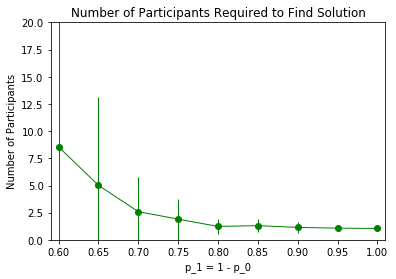

In [13]:
plt.figure(1)
plt.errorbar(rates, mean_num_participants, std_num_participants, fmt='-og', lw=1)

plt.title('Number of Participants Required to Find Solution')
plt.xlabel('p_1 = 1 - p_0')
plt.ylabel('Number of Participants')
plt.ylim(1, 20)
plt.xlim(0.59, 1.01)

# Evaluate DQN0 for  Heuristic reward

In [7]:
def evaluateDQN0(env, DQN, render = False):
    state = env.reset_left()
    passedLeft = False
    
    for step in range(1000):
        #Get action from DQN   
        dumb_package_pytorch = FloatTensor(np.array([state]))
        _ , action = torch.max(DQN(dumb_package_pytorch), 0)
        if use_cuda:
            action_to_take = action.cpu().numpy()
        else:
            action_to_take = action.numpy()
            
        
        #Perform action and render
        next_state, reward, done, _ = env.step(action_to_take, 1)
        if render:
            env.render(display_sr = True, display_hm = True)
        state = next_state
        
        if state <= 0.625 and state >= 0.375:
            passedLeft = True
        else:
            passedLeft = False

    if passedLeft == False:
        return False
    
    state = env.reset_right()
    for step in range(1000):

        #Get action from DQN     
        dumb_package_pytorch = FloatTensor(np.array([state]))
        _ , action = torch.max(DQN(dumb_package_pytorch), 0)
        if use_cuda:
            action_to_take = action.cpu().numpy()
        else:
            action_to_take = action.numpy()

        #Perform action and render
        next_state, reward, done, _ = env.step(action_to_take, 1)
        if render:
            env.render(display_sr = True, display_hm = True)
        state = next_state
        
        if state <= 0.625 and state >= 0.375:
            passedRight = True
        else:
            passedRight = False
        
    return passedLeft and passedRight

#  Function to find initial DQN0

In [8]:
def getInitialDQN0(env, num_episodes = 1000, num_steps_per_episode = 1000, learning_rate = 0.001, batch_size = 256, gamma = 0.95):

    min_epsilon = 0.005
    decay_rate = 5/num_episodes

    ## Initialize Replay Buffer
    replay = Replay()

    #Get NN
    if use_cuda:
        DQN = QNetwork(1, 3, 10).cuda()
        targetDQN = QNetwork(1, 3, 10).cuda()
    else:
        DQN = QNetwork(1, 3, 10)
        targetDQN = QNetwork(1, 3, 10)

    targetDQN.load_state_dict(DQN.state_dict())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(DQN.parameters(), learning_rate)


    #Fill replay with 1000 random actions
    state = env.reset()
    for i in range(1000):
        if i % num_steps_per_episode:
            env.reset()
        action_to_take = env.random_action()
        next_state, reward, done, _ = env.step(action_to_take, 0)
        replay.pushBack(state, action_to_take, reward, next_state, done)
        state = next_state

    total_rewards = np.zeros((num_episodes))    

    #Do actual DQN training
    for ep in range(num_episodes):
        env.reset();
        epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)

        for step in range(num_steps_per_episode):
            # explore/exploit and get action using DQN
            r = np.random.rand()

            if r > epsilon:
                dumb_package_pytorch = FloatTensor(np.array([state]))
                _ , action = torch.max(DQN(dumb_package_pytorch), 0)
                if use_cuda:
                    action_to_take = np.asscalar(action.cpu().numpy())
                else:
                    action_to_take = np.asscalar(action.numpy())
            else:
                action_to_take = env.random_action()

            # perform action and record new_state, action, reward
            next_state, reward, done, _ = env.step(action_to_take, 0)
            #env.render(display_sr = True, display_hm = True)

            # populate Replay experience buffer
            replay.pushBack(state, action_to_take, reward, next_state, done)

            #update state with next state
            state = next_state

            total_rewards[ep] += reward

        #print("ep: {} total reward: {} epsilon: {}".format(ep, total_rewards[ep], epsilon))

        DQN = trainDQN(DQN,targetDQN, criterion, optimizer, replay, gamma, batch_size)


        passed = evaluateDQN0(env, DQN, render=False)

        if passed:
            break
    return DQN, passed

# Using Heuristic Reward for Initailization of DQN

In [9]:
#Initialize DQN for the different enviornments
env_list = []
DQN0_list = []
num_times_to_run = 100


for z in range(num_times_to_run):
    env = cursor1D_env(truePositiveRate = 1, falsePositiveRate = 0)
    
    passed = False
    while passed == False:
        DQN0, passed = getInitialDQN0(env)
    env_list.append(env)
    DQN0_list.append(DQN0)
    
    print("Made DQN {} out of {}".format(z+1, num_times_to_run))
        

Made DQN 1 out of 100
Made DQN 2 out of 100
Made DQN 3 out of 100
Made DQN 4 out of 100
Made DQN 5 out of 100
Made DQN 6 out of 100
Made DQN 7 out of 100
Made DQN 8 out of 100
Made DQN 9 out of 100
Made DQN 10 out of 100
Made DQN 11 out of 100
Made DQN 12 out of 100
Made DQN 13 out of 100
Made DQN 14 out of 100
Made DQN 15 out of 100
Made DQN 16 out of 100
Made DQN 17 out of 100
Made DQN 18 out of 100
Made DQN 19 out of 100
Made DQN 20 out of 100
Made DQN 21 out of 100
Made DQN 22 out of 100
Made DQN 23 out of 100
Made DQN 24 out of 100
Made DQN 25 out of 100
Made DQN 26 out of 100
Made DQN 27 out of 100
Made DQN 28 out of 100
Made DQN 29 out of 100
Made DQN 30 out of 100
Made DQN 31 out of 100
Made DQN 32 out of 100
Made DQN 33 out of 100
Made DQN 34 out of 100
Made DQN 35 out of 100
Made DQN 36 out of 100
Made DQN 37 out of 100
Made DQN 38 out of 100
Made DQN 39 out of 100
Made DQN 40 out of 100
Made DQN 41 out of 100
Made DQN 42 out of 100
Made DQN 43 out of 100
Made DQN 44 out of 1

In [10]:
num_participants = 20

num_trails_per_participants = 50 #Roughly 25 minutes per participant
num_steps_per_trail = 2000 #This is roughly 30 seconds per trial
num_steps_till_next_action = 100 # A new action is taken roughly every 1.5 seconds

num_times_to_run = 100


learning_rate = 0.001
batch_size = 256
gamma = 0.95

rates = np.arange(1.0, 0.55, -0.05)
#rates = [1]


#This will contain the results
mean_num_participants_heur = []
std_num_participants_heur  = []

for rate in rates:
    print("On r = {}".format(rate))
    num_participants_to_solve = []
    
    for z in range(num_times_to_run):
        print("{} out of {}".format(z+1, num_times_to_run))  
        
        env = env_list[z]
        env.truePositiveRate = rate
        env.falsePositiveRate = 1 - rate
        
        DQN0 = DQN0_list[z]
        
        ## Initialize Replay Buffer
        replay = Replay(num_participants*num_trails_per_participants*num_steps_per_trail)
                
        epsilon = rate
        #Collect data
        for part in range(1, num_participants+1):

            for trail in range(num_trails_per_participants):
                state = env.reset();

                for step in range(num_steps_per_trail):

                    # Get action
                    if step % num_steps_till_next_action == 0:
                        r = np.random.rand()
                        if r > epsilon:
                            dumb_package_pytorch = FloatTensor(np.array([state]))
                            _ , action = torch.max(DQN(dumb_package_pytorch), 0)
                            if use_cuda:
                                action_to_take = np.asscalar(action.cpu().numpy())
                            else:
                                action_to_take = np.asscalar(action.numpy())
                        else:
                            action_to_take = env.random_action()

                    # perform action and record new_state, action, reward
                    next_state, reward, done, _ = env.step(action_to_take, 1)
                    #env.render(display_sr = True, display_hm = True)

                    # populate Replay experience buffer
                    replay.pushBack(state, action_to_take, reward, next_state, done)

                    #update state with next state
                    state = next_state    
            
            if (part-1) % 1 == 0:
                print("Number of participants {}".format(part))
                #Train a NN with the data we have so far.
                learning_rate = 0.005
        
                if use_cuda:
                    DQN = QNetwork(1, 3, 10).cuda()
                    targetDQN = QNetwork(1, 3, 10).cuda()
                else:
                    DQN = QNetwork(1, 3, 10)
                    targetDQN = QNetwork(1, 3, 10)
                    
                #Preload DQN weights with DQN0
                DQN.load_state_dict(DQN0.state_dict())
                targetDQN.load_state_dict(DQN.state_dict())
                
                criterion = nn.MSELoss()
                optimizer = optim.Adam(DQN.parameters(), learning_rate)

                for i in range(10000):
                    DQN = trainDQN(DQN,targetDQN, criterion, optimizer, replay, gamma, batch_size)
                    if i%100 == 0 and i != 0:
                        passed = evaluateDQN(env, DQN, render = False)
                        if passed:
                            break

                #If DQN managed to solve the environment we are done!
                if passed:
                    num_participants_to_solve.append(part)
                    break
                
                
    num_participants_to_solve = np.array(num_participants_to_solve)
    
    mean_num_participants_heur.append(np.mean(num_participants_to_solve))
    std_num_participants_heur.append(np.std(num_participants_to_solve))
    
    print("Solved r = {} with mean = {} and std = {}".format(rate, mean_num_participants_heur[-1], std_num_participants_heur[-1]))
        

On r = 1.0
1 out of 100
Number of participants 1
2 out of 100
Number of participants 1
3 out of 100
Number of participants 1
4 out of 100
Number of participants 1
5 out of 100
Number of participants 1
6 out of 100
Number of participants 1
7 out of 100
Number of participants 1
8 out of 100
Number of participants 1
9 out of 100
Number of participants 1
10 out of 100
Number of participants 1
11 out of 100
Number of participants 1
12 out of 100
Number of participants 1
13 out of 100
Number of participants 1
14 out of 100
Number of participants 1
15 out of 100
Number of participants 1
16 out of 100
Number of participants 1
17 out of 100
Number of participants 1
18 out of 100
Number of participants 1
19 out of 100
Number of participants 1
20 out of 100
Number of participants 1
21 out of 100
Number of participants 1
22 out of 100
Number of participants 1
23 out of 100
Number of participants 1
24 out of 100
Number of participants 1
25 out of 100
Number of participants 1
26 out of 100
Number of

72 out of 100
Number of participants 1
73 out of 100
Number of participants 1
74 out of 100
Number of participants 1
Number of participants 2
75 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
76 out of 100
Number of participants 1
77 out of 100
Number of participants 1
78 out of 100
Number of participants 1
79 out of 100
Number of participants 1
80 out of 100
Number of participants 1
81 out of 100
Number of participants 1
82 out of 100
Number of participants 1
83 out of 100
Number of participants 1
84 out of 100
Number of participants 1
85 out of 100
Number of participants 1
86 out of 100
Number of participants 1
87 out of 100
Number of participants 1
88 out of 100
Number of participants 1
89 out of 100
Number of participants 1
90 out of 100
Number of participants 1
Number of participants 2
91 out of 100
Number of participants 1
92 out of 100
Number of participants 1
Number of participants 2
Number

Number of participants 2
23 out of 100
Number of participants 1
24 out of 100
Number of participants 1
25 out of 100
Number of participants 1
Number of participants 2
26 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
Number of participants 6
Number of participants 7
Number of participants 8
Number of participants 9
Number of participants 10
Number of participants 11
Number of participants 12
Number of participants 13
Number of participants 14
Number of participants 15
27 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
Number of participants 6
Number of participants 7
Number of participants 8
Number of participants 9
Number of participants 10
Number of participants 11
Number of participants 12
Number of participants 13
Number of participants 14
Number of participants 15
Number of participants 16
Number of partici

Number of participants 3
Number of participants 4
Number of participants 5
43 out of 100
Number of participants 1
44 out of 100
Number of participants 1
45 out of 100
Number of participants 1
Number of participants 2
46 out of 100
Number of participants 1
47 out of 100
Number of participants 1
48 out of 100
Number of participants 1
49 out of 100
Number of participants 1
Number of participants 2
50 out of 100
Number of participants 1
51 out of 100
Number of participants 1
52 out of 100
Number of participants 1
53 out of 100
Number of participants 1
54 out of 100
Number of participants 1
55 out of 100
Number of participants 1
56 out of 100
Number of participants 1
57 out of 100
Number of participants 1
58 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
Number of participants 6
59 out of 100
Number of participants 1
60 out of 100
Number of participants 1
61 out of 100
Number of participants 1
62 out of

Number of participants 1
Number of participants 2
59 out of 100
Number of participants 1
60 out of 100
Number of participants 1
61 out of 100
Number of participants 1
62 out of 100
Number of participants 1
63 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
64 out of 100
Number of participants 1
65 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
66 out of 100
Number of participants 1
Number of participants 2
67 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
68 out of 100
Number of participants 1
69 out of 100
Number of participants 1
70 out of 100
Number of participants 1
71 out of 100
Number of participants 1
72 out of 100
Number of participants 1
Number of participants 2
73 out of 100
Number of participants 1
74 out of 100
Number of participants 1
75 out of 100
Number of participants 1
76 out of 100
Number of participants 1
Number of participants 

Number of participants 2
62 out of 100
Number of participants 1
63 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
64 out of 100
Number of participants 1
65 out of 100
Number of participants 1
66 out of 100
Number of participants 1
67 out of 100
Number of participants 1
Number of participants 2
68 out of 100
Number of participants 1
69 out of 100
Number of participants 1
70 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
Number of participants 6
71 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
72 out of 100
Number of participants 1
Number of participants 2
73 out of 100
Number of participants 1
74 out of 100
Number of participants 1
Number of participants 2
75 out of 100
Number of participants 1
76 out of 100
Number of participants 1
Number of participants 2
Number of parti

Number of participants 10
Number of participants 11
Number of participants 12
Number of participants 13
Number of participants 14
59 out of 100
Number of participants 1
60 out of 100
Number of participants 1
61 out of 100
Number of participants 1
Number of participants 2
62 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
63 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
Number of participants 6
Number of participants 7
Number of participants 8
Number of participants 9
Number of participants 10
64 out of 100
Number of participants 1
65 out of 100
Number of participants 1
66 out of 100
Number of participants 1
67 out of 100
Number of participants 1
Number of participants 2
68 out of 100
Number of participants 1
69 out of 100
Number of participants 1
70 out of 100
Number of participants 1
Number of participants 2
N

Number of participants 13
Number of participants 14
Number of participants 15
Number of participants 16
Number of participants 17
Number of participants 18
Number of participants 19
Number of participants 20
39 out of 100
Number of participants 1
40 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
Number of participants 6
Number of participants 7
Number of participants 8
Number of participants 9
Number of participants 10
Number of participants 11
41 out of 100
Number of participants 1
Number of participants 2
42 out of 100
Number of participants 1
Number of participants 2
Number of participants 3
Number of participants 4
Number of participants 5
Number of participants 6
Number of participants 7
Number of participants 8
Number of participants 9
Number of participants 10
Number of participants 11
Number of participants 12
Number of participants 13
Number of participants 14
Number of participants 15
Num

In [15]:
print(mean_num_participants_heur)
print(std_num_participants_heur)
rates_huer = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]

[1.101010101010101, 1.1818181818181819, 1.3061224489795917, 1.5757575757575757, 1.7040816326530612, 1.989795918367347, 2.2989690721649483, 2.1382978723404253, 2.3846153846153846]
[0.5411351610496514, 0.6721537276611768, 1.3732737829600588, 1.6148984962999062, 1.7095719936578793, 2.3277163108198584, 2.4459726986093773, 2.210232797163015, 3.1545161443267746]


In [15]:
mean_num_participants_heur = [1.101010101010101 , 1.1818181818181819 , 1.3061224489795917, 1.5757575757575757, 1.7040816326530612, 1.989795918367347, 2.2989690721649483, 2.1382978723404253, 2.3846153846153846]
std_num_participants_heur  = [0.5411351610496514, 0.6721537276611768 , 1.3732737829600588, 1.6148984962999062, 1.7095719936578793, 2.3277163108198584, 2.4459726986093773, 2.210232797163015, 3.1545161443267746]
rates_huer = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]

(0.59, 1.01)

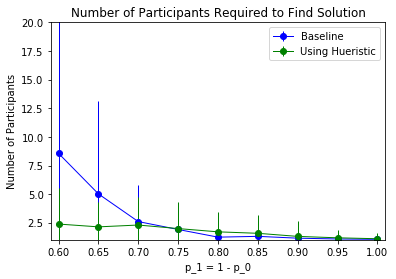

In [16]:
plt.figure(1)
plt.errorbar(rates, mean_num_participants, std_num_participants, fmt='-ob', lw=1, label="Baseline")
plt.errorbar(rates_huer, mean_num_participants_heur, std_num_participants_heur, fmt='-og', lw=1, label="Using Hueristic")
plt.legend()

plt.title('Number of Participants Required to Find Solution')
plt.xlabel('p_1 = 1 - p_0')
plt.ylabel('Number of Participants')
plt.ylim(1, 20)
plt.xlim(0.59, 1.01)